In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob
import regionmask
import xarray as xr
import numpy as np

Calling the two datasets (ERA5 and the Borough Boundaries across Alaska)

In [2]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]
})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)

Test case over just 12/2021 Due to know ROS event

In [3]:
path='/import/beegfs/CMIP6/wrf_era5/04km'
year='2021'
month='12'

folder = os.path.join(path, year)
pattern = f"era5_wrf_dscale_4km_{year}-{month}-*.nc"
file_list = sorted(glob.glob(os.path.join(folder, pattern)))
data = xr.open_mfdataset(file_list, combine='by_coords')
lat=data['XLAT']
lon=data['XLONG']

Masking the two datasets

In [4]:
def borough_land_mask(shapefile,data,lat,lon):
    mask = regionmask.mask_geopandas(shapefile, lon, lat)
    data_masked = data.where(~np.isnan(mask))
    
    os.chdir("/import/beegfs/CMIP6/wrf_era5")
    geo_em_path = "geo_em.d02.nc"
    geo = xr.open_dataset(geo_em_path)
    landmask = geo['LANDMASK']
    landmask=landmask.squeeze(dim="Time")
    landmask_expanded = landmask.expand_dims(Time=data_masked.Time)

    data_fixed = data_masked.where(landmask_expanded== 1)
    data_fixed = data_fixed.chunk(dict(south_north=-1, west_east=-1))
    data_filled = data_fixed.interpolate_na(dim="south_north", method="nearest", fill_value="extrapolate")
    data_filled = data_filled.interpolate_na(dim="west_east", method="nearest", fill_value="extrapolate")
    data_final = data_filled.where(~np.isnan(mask))
    return data_final


In [4]:
def test_borough_land_mask(shapefile,data,lat,lon):
    mask = regionmask.mask_geopandas(shapefile, lon, lat)
    data_masked = data.where(~np.isnan(mask))
    
    os.chdir("/import/beegfs/CMIP6/wrf_era5")
    geo_em_path = "geo_em.d02.nc"
    geo = xr.open_dataset(geo_em_path)
    landmask = geo['LANDMASK']
    landmask=landmask.squeeze(dim="Time")
    landmask_expanded = landmask.expand_dims(Time=data_masked.Time)

    data_fixed = data_masked.where(landmask_expanded== 1)
    data_fixed = data_fixed.chunk(dict(south_north=-1, west_east=-1))
    return data_fixed

In [6]:
FNSB_data=test_borough_land_mask(FNSB_boundary,data,lat,lon)


In [7]:
mean_FNSB_T2=np.mean(FNSB_data['T2'],axis=0)

(230.0, 280.0)

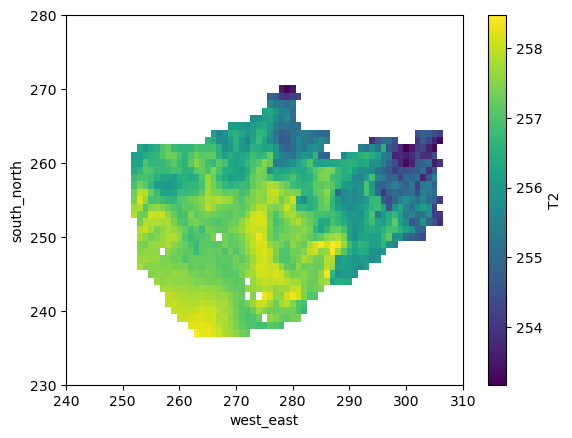

In [12]:
mean_FNSB_T2.plot()
plt.xlim(240,310)
plt.ylim(230,280)

In [5]:
FNSB_data=borough_land_mask(FNSB_boundary,data,lat,lon)

FNSB_T2=FNSB_data['T2']
FNSB_SNOW=FNSB_data['SNOW']
FNSB_ACSNOW=FNSB_data['acsnow']
FNSB_RAINC=FNSB_data['rainc'] #convective 
FNSB_RAINNC=FNSB_data['rainnc']
FNSB_RAIN=FNSB_RAINNC-FNSB_ACSNOW

In [6]:
mean_FNSB_T2=np.mean(FNSB_data['T2'],axis=0)

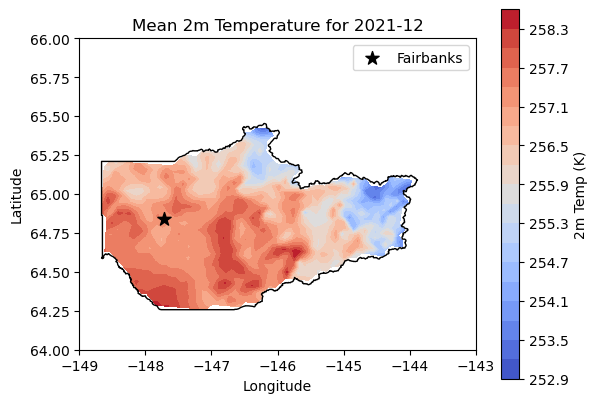

In [7]:
fig, ax = plt.subplots()  
cf = ax.contourf(lon, lat, mean_FNSB_T2, levels=20, cmap='coolwarm')
cbar = fig.colorbar(cf, ax=ax, label='2m Temp (K)')
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2)  
ax.set_title(f"Mean 2m Temperature for {year}-{month}")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=100,label='Fairbanks')
ax.legend(loc='upper right')
plt.show()

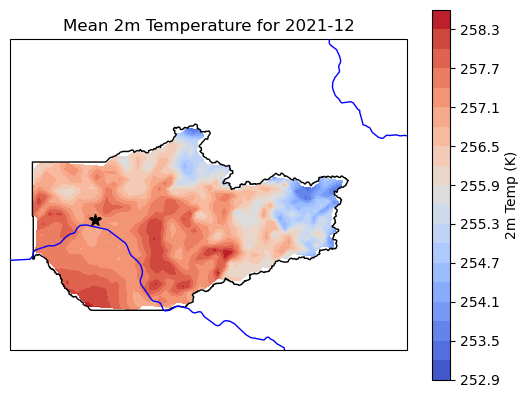

In [8]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})  
cf = ax.contourf(lon, lat, np.mean(FNSB_T2, axis=0), levels=20, cmap='coolwarm',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='2m Temp (K)')
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2,transform=ccrs.PlateCarree())  

rivers = cfeature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='10m', facecolor='none', edgecolor='blue',transform=ccrs.PlateCarree())
ax.add_feature(rivers, linewidth=1.0, zorder=3)

ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*',color='k', zorder=5,s=75,label='Fairbanks')
ax.set_title(f"Mean 2m Temperature for {year}-{month}")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

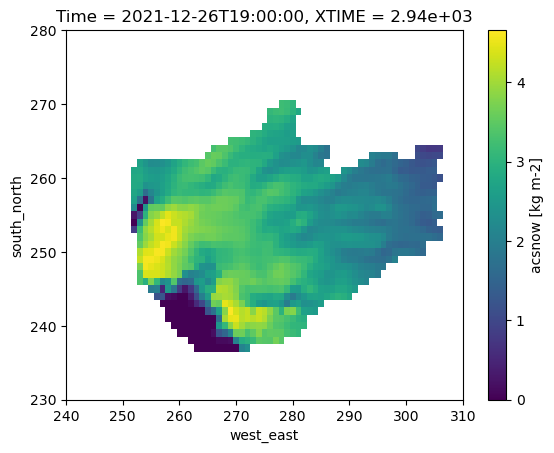

In [9]:
FNSB_ACSNOW.isel(Time=619).plot()
plt.xlim(240, 310)
plt.ylim(230, 280)
plt.show()

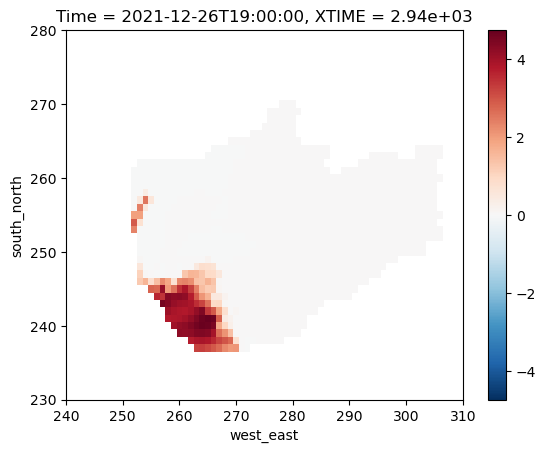

In [10]:
FNSB_RAIN.isel(Time=619).plot()
plt.xlim(240, 310)
plt.ylim(230, 280)
plt.show()

In [11]:
'''
#Raw script before making it into the function above
mask = regionmask.mask_geopandas(FNSB_boundary, lon, lat)
data_masked = data.where(~np.isnan(mask))

os.chdir("/import/beegfs/CMIP6/wrf_era5")
geo_em_path = "geo_em.d02.nc"
geo = xr.open_dataset(geo_em_path)
landmask = geo['LANDMASK']
landmask=landmask.squeeze(dim="Time")
landmask_expanded = landmask.expand_dims(Time=data_masked_FNSB.Time)

data_fixed = data_masked.where(landmask_expanded== 1)
data_fixed = data_fixed.chunk(dict(south_north=-1, west_east=-1))
data_filled = data_fixed.interpolate_na(dim="south_north", method="nearest", fill_value="extrapolate")
data_filled = data_filled.interpolate_na(dim="west_east", method="nearest", fill_value="extrapolate")

#Same mask as before--do this so it removed the outside boundary again (mask = regionmask.mask_geopandas(FNSB_boundary, lon, lat))
data_filled = data_filled.where(~np.isnan(mask))
'''

'\n#Raw script before making it into the function above\nmask = regionmask.mask_geopandas(FNSB_boundary, lon, lat)\ndata_masked = data.where(~np.isnan(mask))\n\nos.chdir("/import/beegfs/CMIP6/wrf_era5")\ngeo_em_path = "geo_em.d02.nc"\ngeo = xr.open_dataset(geo_em_path)\nlandmask = geo[\'LANDMASK\']\nlandmask=landmask.squeeze(dim="Time")\nlandmask_expanded = landmask.expand_dims(Time=data_masked_FNSB.Time)\n\ndata_fixed = data_masked.where(landmask_expanded== 1)\ndata_fixed = data_fixed.chunk(dict(south_north=-1, west_east=-1))\ndata_filled = data_fixed.interpolate_na(dim="south_north", method="nearest", fill_value="extrapolate")\ndata_filled = data_filled.interpolate_na(dim="west_east", method="nearest", fill_value="extrapolate")\n\n#Same mask as before--do this so it removed the outside boundary again (mask = regionmask.mask_geopandas(FNSB_boundary, lon, lat))\ndata_filled = data_filled.where(~np.isnan(mask))\n'